# ICP08 DNN - Assignment

In this exercise I will update 03-keras-hyperparameter-tuning by adding a model loss and model accuracy plot.

MNIST data set;

![mnist data](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

## Imports and Initialization

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # (levels are 0 to 2 - default is 0; warnings are 1 and errors are 2)
import tensorflow as tf


In [2]:
from __future__ import print_function
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from sklearn import datasets

np.random.seed(1)

## Load data (shouldn't need any transformations)

> NOTE1: The features of this data are all pixel grayscale values.  All of these measures are the same scale, so we don't need to do any scaling or normalization. If we did have differing scales, we should be sure to scale them to the same range. Neural networks are sensitive to scale, and features with larger scales can dominate the training process.

> NOTE2: Some might argue that you should scale every time your fit a neural network. This is a good idea, but it is not necessary if you are using a good optimizer.  We will use the Adam optimizer, which is a good optimizer.

Load the MNIST digits dataset. It's originally from UCI machine learning library, but included in SKLearn.

In [3]:
mnist = datasets.load_digits() # sklearn includes this data set .. https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

In [4]:
print(len(mnist.data))

1797


And, for each image we have a target value

In [5]:
print(len(mnist.target))

1797


## Split data into training and test sets


In [6]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.2, random_state=1)

## Keras Hyperparameter tuning

Import the libraries we will use

In [7]:
import keras_tuner # you will most likely need to install this using ```conda install -c conda-forge keras-tuner``` or ```pip install keras-tuner```
from tensorflow import keras
from tensorflow.keras import layers

Create a function that builds the model. This is used by random search to generate a model for each set of paramete values that keras tuner's RandomSearch function generates. 

Notice that there are a number of references to 'hp' in this function. Hp is a keras hyper parameter object that RandomSearch will send to our build_model function. The hp.Boolean, hb.Int, hp.Float methods will generate a random value based on the parameters given to each method. 

These hyperparameter randomization methods are well documented [here](https://keras.io/api/keras_tuner/hyperparameters/).
* hp.Boolean
* hp.Int
* hp.Float
* hp.Choice

The build_model function will use the random values to create a Keras sequential neural network and return it back to the calling function (RandomSearch that is calling this function)
* [Input layer](https://keras.io/api/layers/core_layers/input/)
* [Dropout layer](https://keras.io/api/layers/regularization_layers/dropout/)
* [Normalization layer](http://keras.io/api/layers/preprocessing_layers/numerical/normalization/)
* [Dense layer](https://keras.io/api/layers/core_layers/dense/)


In [8]:
def build_mnist_model(hp):
    model = keras.Sequential()

    # create input layer
    model.add(layers.Input(64))

    # create hidden layers
    for i in range(hp.Int(name='hidden_layer_count', min_value=1, max_value=5, step=1)):
        model.add(layers.Dense(
            units=hp.Int("units", min_value=32, max_value=1024, step=32),
            activation=hp.Choice("activation", ["selu", "elu", "relu", "tanh"])
            ) 
        )

    model.add(layers.Dense(units=10, activation="softmax"))

    # Define the optimizer learning rate as a hyperparameter.
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2)   
    decay = hp.Float("lr", min_value=0, max_value=1e-4)   
    choice = hp.Choice(name='optimizer', values=['adam', 'sgd'])
    if 'adam' == choice:
#        optimizer = keras.optimizers.legacy.Adam(learning_rate=lr)
        optimizer = keras.optimizers.legacy.Adam(learning_rate=lr, decay=decay)
    else:
#        optimizer = keras.optimizers.legacy.SGD(learning_rate=lr) 
        optimizer = keras.optimizers.legacy.SGD(learning_rate=lr, decay=decay)  

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [9]:
build_mnist_model(keras_tuner.HyperParameters())

We now use our model generating function to conduct a random search to identify the best fitting model (from a random selection of the parameter ranges identified in the build_model function we created above).

NOTE: That the number of trials represents the number of unique combinations of hyperparameters that will be tested. the executions per trial are how many trials of of a model with this chosen set of parameters will be tested. So, if we have 10 trials and 3 executions, we will train 30 times... 3 times per each 10 sets of parameters.

In [10]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_mnist_model,
    objective="accuracy",
    max_trials=25, # max_trials represents the number of hyperparameter combinations that will be tested by the tuner (like n_iter in sklearn random search)
    executions_per_trial=2, # max number of models to fit per set of set of hyperparameters combinations
    directory='keras_tuner_dir',
    project_name='kt_intro_mnist',
    overwrite=True
)

tuner.save()


Get a summary of the overal 'search space' (all the possible paremater values).

In [11]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
hidden_layer_count (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 1024, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'selu', 'conditions': [], 'values': ['selu', 'elu', 'relu', 'tanh'], 'ordered': False}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd'], 'ordered': False}


Train the model...

In [12]:
%%time
tuner.search(X_train, y_train, epochs=10, batch_size=13, validation_data=(X_test, y_test))

Trial 25 Complete [00h 00m 17s]
accuracy: 0.9993041157722473

Best accuracy So Far: 1.0
Total elapsed time: 00h 07m 33s
INFO:tensorflow:Oracle triggered exit
CPU times: total: 27min 18s
Wall time: 7min 33s


In [13]:
histories = []

In [14]:
for best_model in tuner.get_best_models(num_models=5):
    best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              66560     
                                                                 
 dense_1 (Dense)             (None, 10)                10250     
                                                                 
Total params: 76,810
Trainable params: 76,810
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 736)               47840     
                                                                 
 dense_1 (Dense)             (None, 736)               542432    
                                                                 
 dense_2 (Dense)             (No

In [15]:
tuner.results_summary()

Results summary
Results in keras_tuner_dir\kt_intro_mnist
Showing 10 best trials
Objective(name="accuracy", direction="max")

Trial 01 summary
Hyperparameters:
hidden_layer_count: 1
units: 1024
activation: selu
lr: 0.004509248348283874
optimizer: adam
Score: 1.0

Trial 10 summary
Hyperparameters:
hidden_layer_count: 3
units: 736
activation: elu
lr: 0.002646990167532869
optimizer: adam
Score: 1.0

Trial 16 summary
Hyperparameters:
hidden_layer_count: 1
units: 512
activation: selu
lr: 0.006349380983864907
optimizer: adam
Score: 1.0

Trial 17 summary
Hyperparameters:
hidden_layer_count: 1
units: 704
activation: tanh
lr: 0.007488291519549304
optimizer: adam
Score: 1.0

Trial 20 summary
Hyperparameters:
hidden_layer_count: 2
units: 480
activation: tanh
lr: 0.0008343647183259987
optimizer: adam
Score: 1.0

Trial 18 summary
Hyperparameters:
hidden_layer_count: 1
units: 160
activation: elu
lr: 0.0032854510509754903
optimizer: adam
Score: 0.9996520578861237

Trial 24 summary
Hyperparameters:
hi

In [16]:
best_hps = tuner.get_best_hyperparameters(5)
best_hps[0].values

{'hidden_layer_count': 1,
 'units': 1024,
 'activation': 'selu',
 'lr': 0.004509248348283874,
 'optimizer': 'adam'}

Let's get an overview of the structure of the top model (set of parameters) found.

In [17]:
# Get list of the top 2 models.
#models = tuner.get_best_models(num_models=1)
models = tuner.get_best_models()

# select the first one in the list (this is the best performing model)
best_model = models[0] # select the first one

# display summary of model training
best_model.summary()

# NOTE: If you get them, y=ou can ignore warnings about tf.train.Checkpoint.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              66560     
                                                                 
 dense_1 (Dense)             (None, 10)                10250     
                                                                 
Total params: 76,810
Trainable params: 76,810
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = best_model.fit(X_train, y_train, epochs=20, batch_size=111, validation_data=(X_test, y_test))

Epoch 1/20
13/13 [==============================] - 2s 53ms/step - loss: 9.2554e-04 - accuracy: 1.0000 - val_loss: 0.1021 - val_accuracy: 0.9778
Epoch 2/20
13/13 [==============================] - 0s 10ms/step - loss: 9.1260e-04 - accuracy: 1.0000 - val_loss: 0.1008 - val_accuracy: 0.9806
Epoch 3/20
13/13 [==============================] - 0s 11ms/step - loss: 7.0316e-04 - accuracy: 1.0000 - val_loss: 0.0997 - val_accuracy: 0.9806
Epoch 4/20
13/13 [==============================] - 0s 17ms/step - loss: 5.9138e-04 - accuracy: 1.0000 - val_loss: 0.0992 - val_accuracy: 0.9833
Epoch 5/20
13/13 [==============================] - 0s 17ms/step - loss: 5.6502e-04 - accuracy: 1.0000 - val_loss: 0.0990 - val_accuracy: 0.9833
Epoch 6/20
13/13 [==============================] - 0s 9ms/step - loss: 5.5928e-04 - accuracy: 1.0000 - val_loss: 0.0986 - val_accuracy: 0.9833
Epoch 7/20
13/13 [==============================] - 0s 10ms/step - loss: 5.4833e-04 - accuracy: 1.0000 - val_loss: 0.0985 - val_acc

In [19]:
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Loss {loss:.5f}\nAccuracy {accuracy:.5f}")

12/12 [==============================] - 0s 3ms/step - loss: 0.0974 - accuracy: 0.9806
Loss 0.09739
Accuracy 0.98056


In [20]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


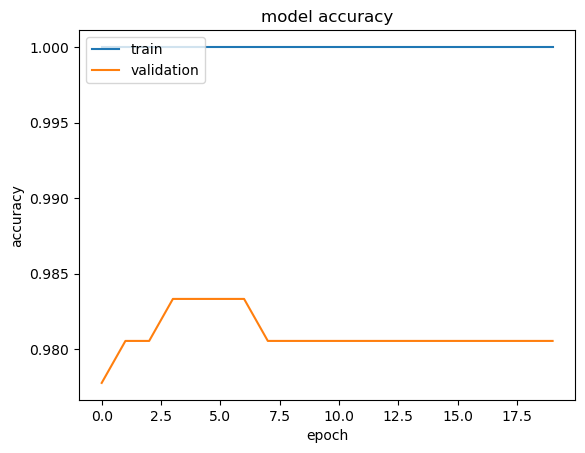

In [21]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


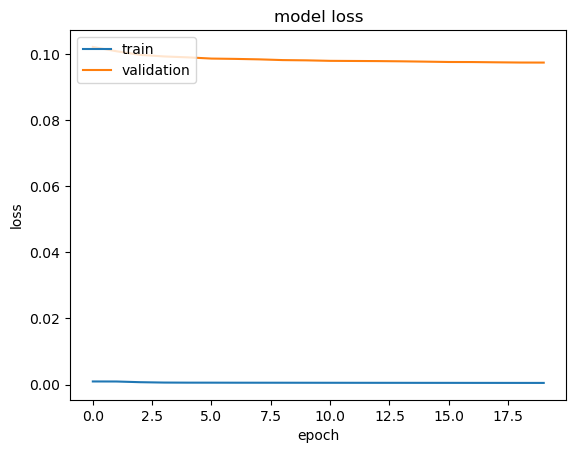

In [22]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Investigating the Confusion Matrix

We can use sklearn's classification report and confusion matrix functions to see how well our model did at predicting the correct digit.

First though, we need get predictions from our model for the test data. 

In [23]:
y_pred = best_model.predict(X_test)

12/12 [==============================] - 0s 1ms/step


But, the resulting predictions are an array of 10 values, each with a probability associated with each of the 10 digits. We need to convert this to a single digit prediction. We can do this by using the argmax function to get the index of the highest probability value.

In [24]:
y_pred[0] # note that the results from the model are probabilities for each class

array([3.4696111e-16, 9.9965072e-01, 3.4276202e-12, 1.0881993e-14,
       6.2508105e-09, 1.4317520e-13, 6.5610811e-10, 1.4615162e-11,
       3.4923427e-04, 7.3334022e-10], dtype=float32)

In [25]:
y_pred[0].sum() # the probabilities sum to 1; this is a requirement for a softmax output layer

0.99999994

In [26]:
y_pred = y_pred.argmax(axis=1) # convert the probabilities to class labels

In [27]:
y_pred[0:10] # the class labels for the first 10 test samples


array([1, 5, 0, 7, 1, 0, 6, 1, 5, 4], dtype=int64)

Now that we have the labeled predictions, let's use these to evaluate the model peformance and diplay the confusion matrix.

In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.9767    0.9882        43
           1     1.0000    1.0000    1.0000        35
           2     1.0000    1.0000    1.0000        36
           3     0.9762    1.0000    0.9880        41
           4     0.9500    1.0000    0.9744        38
           5     0.9062    0.9667    0.9355        30
           6     1.0000    1.0000    1.0000        37
           7     1.0000    0.9189    0.9577        37
           8     0.9655    0.9655    0.9655        29
           9     1.0000    0.9706    0.9851        34

    accuracy                         0.9806       360
   macro avg     0.9798    0.9798    0.9794       360
weighted avg     0.9814    0.9806    0.9806       360



[(0, 43), (1, 35), (2, 36), (3, 41), (4, 38), (5, 30), (6, 37), (7, 37), (8, 29), (9, 34)]


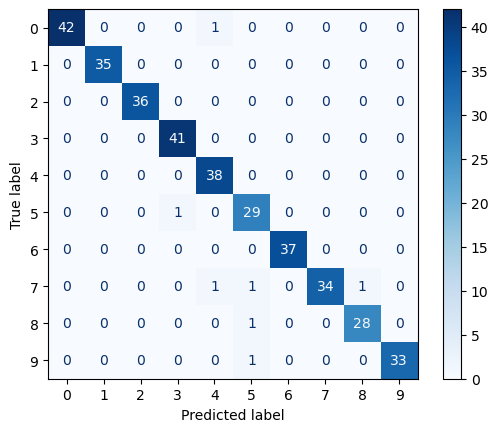

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import collections

# for reference, list the frequency of each digit found in the y_test data
print(sorted(collections.Counter(y_test).items(), key=lambda i: i[0]))
      
# display the confusion matrix
cm = confusion_matrix(y_test, y_pred)  #
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Evaluate The Model's Performance
Now, we need to evaluate the model on the test data. We can do this with the evaluate() method.

## Plots discussion

#### Note: I used hyperparameter tuning to get the best model and then refitted that best model
**Accuracy vs Epochs:** The model has achieved 100% accuracy on the training set, which is excellent for the MNIST dataset since it is relatively simple and clean. However, the validation accuracy being stuck at around 97.78% which suggests that there might be some examples in the test set that are inherently difficult to classify, perhaps due to the handwriting or digit style.

**Loss vs Epochs:** The training loss is consistently decreasing, indicating that the model is learning and improving its predictions on the training data with each epoch. However, the validation loss appears to be more or less constant, with very slight fluctuations. The model seems to achieve its minimum validation loss at around epoch 6, after which it very slightly increases. This indicates that the model might not be generalizing well to the validation data after the 6th epoch.

In the case of using MNIST data, it's worth noting that 97.78% accuracy on the validation set is a reasonable result. This is a relatively high level of accuracy, given the complexity and variability of handwritten digits. But as I used hyperparameter tuning to get the best model and then refitted that model, a higher accuracy is obvious considering that DNNs are capable of achieving above 99% accuracy on this dataset.